In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

In [2]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.config.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Found GPU at: /device:GPU:0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [30]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_new4', 'X_train.npy'))
    labels = np.load(os.path.join('Data_new4', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_new4', 'X_test.npy'))
    labels = np.load(os.path.join('Data_new4', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [36]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16')
test_images = test_images.astype('uint16')

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

Train size: 2913 	 Test size: 655
Image size: 256x256


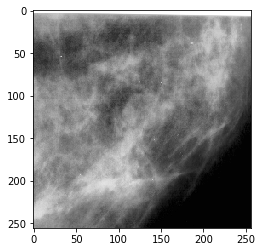

Label: [0. 1. 0. 0.]
[[[  3   3   3]
  [  3   3   3]
  [  3   3   3]
  ...
  [  2   2   2]
  [  2   2   2]
  [  2   2   2]]

 [[  3   3   3]
  [  3   3   3]
  [  3   3   3]
  ...
  [  2   2   2]
  [  2   2   2]
  [  2   2   2]]

 [[  3   3   3]
  [  3   3   3]
  [  3   3   3]
  ...
  [  2   2   2]
  [  2   2   2]
  [  2   2   2]]

 ...

 [[113 113 113]
  [122 122 122]
  [128 128 128]
  ...
  [115 115 115]
  [115 115 115]
  [107 107 107]]

 [[116 116 116]
  [117 117 117]
  [122 122 122]
  ...
  [120 120 120]
  [108 108 108]
  [119 119 119]]

 [[121 121 121]
  [128 128 128]
  [108 108 108]
  ...
  [102 102 102]
  [107 107 107]
  [107 107 107]]]


In [39]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 100

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

print(train_images[0])

In [33]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg19(verbose=False, fc_size=256, dropout=None):

    vgg19_base = VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg19 = models.Sequential()
    vgg19.add(vgg19_base)

    vgg19.add(layers.Flatten())
    if dropout is not None:
        vgg19.add(layers.Dropout(dropout))
    vgg19.add(layers.Dense(fc_size, activation='relu'))
    vgg19.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    vgg19_base.trainable = False
    
    if verbose:
        vgg19_base.summary()
        vgg19.summary()

    return vgg19

In [11]:
vgg19_fe_drop_temp = create_vgg19(verbose=True, dropout=0.5, fc_size=256)

80142336/80134624 [==============================] - 7s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [12]:
vgg19_fe_drop_temp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 28,414,276
Trainable params: 8,389,892
Non-trainable params: 20,024,384
_________________________________________________________________


In [13]:
# Instantiate a VGG19 network with custom final layer
vgg19_fe_drop_128 = create_vgg19(dropout=0.5, fc_size=128)

In [15]:
vgg19_fe_drop_128.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 24,219,332
Trainable params: 4,194,948
Non-trainable params: 20,024,384
_________________________________________________________________


In [20]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg19_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg19_fe_drop_128.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Train
history_vgg19_fe_drop_128 = vgg19_fe_drop_128.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2709 - accuracy: 0.4253
Epoch 00001: val_loss improved from inf to 1.27331, saving model to vgg19_fe_drop_128_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.2691 - accuracy: 0.4247 - val_loss: 1.2733 - val_accuracy: 0.4244
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2249 - accuracy: 0.4344
Epoch 00002: val_loss improved from 1.27331 to 1.26725, saving model to vgg19_fe_drop_128_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.2249 - accuracy: 0.4354 - val_loss: 1.2672 - val_accuracy: 0.4192
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2375 - accuracy: 0.4371
Epoch 00003: val_loss did not improve from 1.26725
19/19 [==============================] - 29s 2s/step - loss: 1.2400 - accuracy: 0.4372 - val_loss: 1.2751 - val_acc

Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1679 - accuracy: 0.4830
Epoch 00029: val_loss did not improve from 1.21154
19/19 [==============================] - 29s 2s/step - loss: 1.1711 - accuracy: 0.4813 - val_loss: 1.2286 - val_accuracy: 0.4347
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1642 - accuracy: 0.4916
Epoch 00030: val_loss did not improve from 1.21154
19/19 [==============================] - 29s 2s/step - loss: 1.1655 - accuracy: 0.4912 - val_loss: 1.2239 - val_accuracy: 0.4622
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1666 - accuracy: 0.4825
Epoch 00031: val_loss did not improve from 1.21154
19/19 [==============================] - 29s 2s/step - loss: 1.1694 - accuracy: 0.4831 - val_loss: 1.2464 - val_accuracy: 0.4536
Epoch 32/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1570 - accuracy: 0.4875
Epoch 00032: val_loss did not improve from 1.21154
19/19 [==================

Epoch 58/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1681 - accuracy: 0.4862
Epoch 00058: val_loss did not improve from 1.16941
19/19 [==============================] - 29s 2s/step - loss: 1.1701 - accuracy: 0.4848 - val_loss: 1.2604 - val_accuracy: 0.4261
Epoch 59/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1603 - accuracy: 0.4939
Epoch 00059: val_loss did not improve from 1.16941
19/19 [==============================] - 29s 2s/step - loss: 1.1560 - accuracy: 0.4946 - val_loss: 1.2329 - val_accuracy: 0.4674
Epoch 60/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1348 - accuracy: 0.4902
Epoch 00060: val_loss did not improve from 1.16941
19/19 [==============================] - 29s 2s/step - loss: 1.1383 - accuracy: 0.4886 - val_loss: 1.2211 - val_accuracy: 0.4828
Epoch 61/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1589 - accuracy: 0.5057
Epoch 00061: val_loss did not improve from 1.16941
19/19 [==================

In [22]:
# Save
models.save_model(vgg19_fe_drop_128, 'vgg19_fe_drop_128_4cl_end.h5')

In [23]:
# History of accuracy and loss
tra_loss_fe = history_vgg19_fe_drop_128.history['loss']
tra_acc_fe = history_vgg19_fe_drop_128.history['accuracy']
val_loss_fe = history_vgg19_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg19_fe_drop_128.history['val_accuracy']

In [24]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_fe_drop_128 = models.load_model('vgg19_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg19_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [25]:
print("VGG19 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 81
Epoch [opt]: 51
Valid accuracy [end]: 0.4674
Valid accuracy [opt]: 0.4708
Test accuracy [end]:  0.4794
Test accuracy [opt]:  0.4672
Valid loss [end]: 1.2156
Valid loss [opt]: 1.1694
Test loss [end]:  1.1990
Test loss [opt]:  1.2052


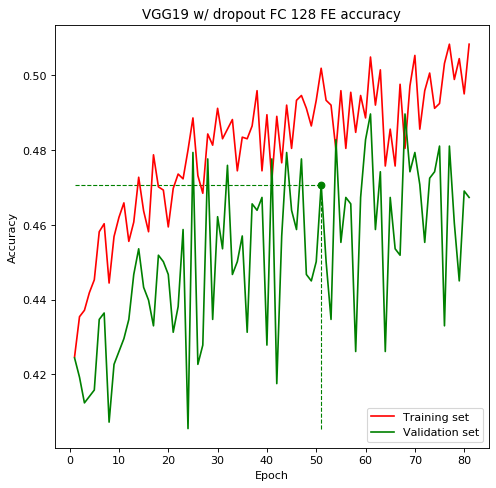

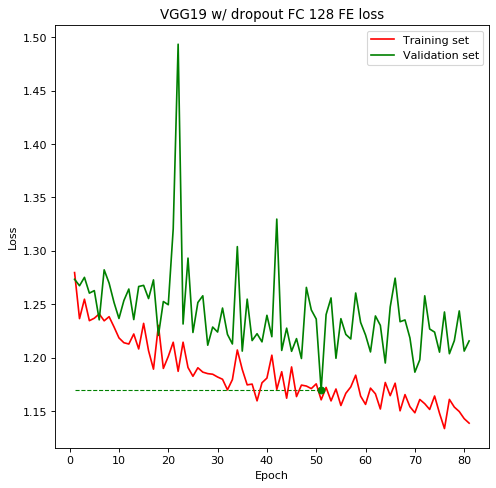

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [27]:
# Instantiate a VGG19 network with custom final layer
vgg19_fe_drop_256 = create_vgg19(dropout=0.5, fc_size=256)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg19_fe_drop_256_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg19_fe_drop_256.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Train
history_vgg19_fe_drop_256 = vgg19_fe_drop_256.fit_generator(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/150
18/19 [===========================>..] - ETA: 1s - loss: 20.8355 - accuracy: 0.3010
Epoch 00001: val_loss improved from inf to 1.37247, saving model to vgg19_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 19.8543 - accuracy: 0.3046 - val_loss: 1.3725 - val_accuracy: 0.2904
Epoch 2/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3755 - accuracy: 0.3409
Epoch 00002: val_loss improved from 1.37247 to 1.36643, saving model to vgg19_fe_drop_256_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.3749 - accuracy: 0.3428 - val_loss: 1.3664 - val_accuracy: 0.3230
Epoch 3/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3607 - accuracy: 0.3559
Epoch 00003: val_loss improved from 1.36643 to 1.35908, saving model to vgg19_fe_drop_256_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1

Epoch 28/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2268 - accuracy: 0.4566
Epoch 00028: val_loss did not improve from 1.23538
19/19 [==============================] - 29s 2s/step - loss: 1.2205 - accuracy: 0.4582 - val_loss: 1.2482 - val_accuracy: 0.4450
Epoch 29/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2244 - accuracy: 0.4557
Epoch 00029: val_loss did not improve from 1.23538
19/19 [==============================] - 29s 2s/step - loss: 1.2091 - accuracy: 0.4577 - val_loss: 1.3255 - val_accuracy: 0.4227
Epoch 30/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1973 - accuracy: 0.4753
Epoch 00030: val_loss did not improve from 1.23538
19/19 [==============================] - 29s 2s/step - loss: 1.1998 - accuracy: 0.4702 - val_loss: 1.2453 - val_accuracy: 0.4450
Epoch 31/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2023 - accuracy: 0.4648
Epoch 00031: val_loss improved from 1.23538 to 1.21886, saving model to vgg1

18/19 [===========================>..] - ETA: 1s - loss: 1.1269 - accuracy: 0.5148
Epoch 00086: val_loss did not improve from 1.17829
19/19 [==============================] - 29s 2s/step - loss: 1.1347 - accuracy: 0.5109 - val_loss: 1.2468 - val_accuracy: 0.4536
Epoch 87/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1301 - accuracy: 0.5039
Epoch 00087: val_loss did not improve from 1.17829
19/19 [==============================] - 29s 2s/step - loss: 1.1346 - accuracy: 0.5019 - val_loss: 1.2223 - val_accuracy: 0.4519
Epoch 88/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1426 - accuracy: 0.4966
Epoch 00088: val_loss did not improve from 1.17829
19/19 [==============================] - 29s 2s/step - loss: 1.1450 - accuracy: 0.4964 - val_loss: 1.2443 - val_accuracy: 0.4296
Epoch 89/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1356 - accuracy: 0.4998
Epoch 00089: val_loss did not improve from 1.17829
19/19 [==============================]

In [29]:
# Save
models.save_model(vgg19_fe_drop_256, 'vgg19_fe_drop_256_4cl_end.h5')

In [30]:
# History of accuracy and loss
tra_loss_fe = history_vgg19_fe_drop_256.history['loss']
tra_acc_fe = history_vgg19_fe_drop_256.history['accuracy']
val_loss_fe = history_vgg19_fe_drop_256.history['val_loss']
val_acc_fe = history_vgg19_fe_drop_256.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_fe_drop_256 = models.load_model('vgg19_fe_drop_256_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg19_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

print("VGG19 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 (w/ dropout) Feature Extraction

Epoch [end]: 107
Epoch [opt]: 77
Valid accuracy [end]: 0.4674
Valid accuracy [opt]: 0.4863
Test accuracy [end]:  0.4626
Test accuracy [opt]:  0.4611
Valid loss [end]: 1.2281
Valid loss [opt]: 1.1783
Test loss [end]:  1.2972
Test loss [opt]:  1.2201


In [31]:
models.load_model('vgg19_fe_drop_128_4cl_best.h5').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 24,219,332
Trainable params: 4,194,948
Non-trainable params: 20,024,384
_________________________________________________________________


In [35]:
vgg19_ft_1layer = models.load_model('vgg19_fe_drop_128_4cl_best.h5')
# Fine tuning: unfreeze the last convolutional layer
for layer in vgg19_ft_1layer.get_layer('vgg19').layers:
    if layer.name.startswith('block5_conv4'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_ft_1layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg19_ft_1layer.summary()
vgg19_ft_1layer.get_layer('vgg19').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 24,219,332
Trainable params: 6,554,756
Non-trainable params: 17,664,576
_________________________________________________________________
Model: "vgg19"
_________________________________________________________________
Layer (type)       

In [36]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg19_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [37]:
# Train
history_ft = vgg19_ft_1layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1693 - accuracy: 0.4834
Epoch 00001: val_loss improved from inf to 1.19635, saving model to vgg19_ft_1layer_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.1664 - accuracy: 0.4835 - val_loss: 1.1963 - val_accuracy: 0.4570
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1374 - accuracy: 0.4880
Epoch 00002: val_loss did not improve from 1.19635
19/19 [==============================] - 29s 2s/step - loss: 1.1340 - accuracy: 0.4882 - val_loss: 1.2188 - val_accuracy: 0.4605
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1186 - accuracy: 0.5157
Epoch 00003: val_loss did not improve from 1.19635
19/19 [==============================] - 29s 2s/step - loss: 1.1202 - accuracy: 0.5157 - val_loss: 1.2283 - val_accuracy: 0.4450
Epoch 4/200
18/19 [====================

Epoch 59/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9942 - accuracy: 0.5712
Epoch 00059: val_loss did not improve from 1.08494
19/19 [==============================] - 29s 2s/step - loss: 0.9711 - accuracy: 0.5744 - val_loss: 1.1825 - val_accuracy: 0.5275
Epoch 60/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9465 - accuracy: 0.5797
Epoch 00060: val_loss did not improve from 1.08494
19/19 [==============================] - 29s 2s/step - loss: 0.9523 - accuracy: 0.5783 - val_loss: 1.1003 - val_accuracy: 0.5223
Epoch 00060: early stopping


In [38]:
# Save
models.save_model(vgg19_ft_1layer, 'vgg19_ft_1layer_4cl_end.h5')

In [39]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_ft_1layer = models.load_model('vgg19_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg19_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG19 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 Fine Tuning

Epoch [end]: 60
Epoch [opt]: 30
Valid accuracy [end]: 0.5223
Valid accuracy [opt]: 0.5155
Test accuracy [end]:  0.5191
Test accuracy [opt]:  0.5160
Valid loss [end]: 1.1003
Valid loss [opt]: 1.0849
Test loss [end]:  1.1073
Test loss [opt]:  1.1178


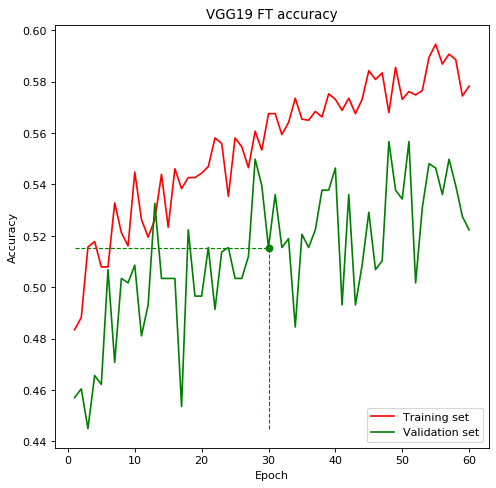

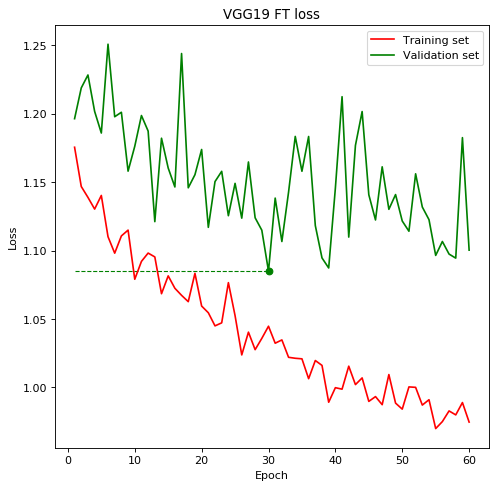

In [40]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [41]:
vgg19_ft_2layer = models.load_model('vgg19_ft_1layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg19_ft_2layer.get_layer('vgg19').layers:
    if layer.name in ('block5_conv3', 'block5_conv4'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_ft_2layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg19_ft_2layer.summary()
vgg19_ft_2layer.get_layer('vgg19').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 24,219,332
Trainable params: 8,914,564
Non-trainable params: 15,304,768
_________________________________________________________________
Model: "vgg19"
_________________________________________________________________
Layer (type)       

In [42]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg19_ft_2layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [43]:
# Train
history_ft_2layer = vgg19_ft_2layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1540 - accuracy: 0.5007
Epoch 00001: val_loss improved from inf to 1.12022, saving model to vgg19_ft_2layer_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.1521 - accuracy: 0.5032 - val_loss: 1.1202 - val_accuracy: 0.5155
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0729 - accuracy: 0.5347
Epoch 00002: val_loss did not improve from 1.12022
19/19 [==============================] - 29s 2s/step - loss: 1.0785 - accuracy: 0.5324 - val_loss: 1.1267 - val_accuracy: 0.4983
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0263 - accuracy: 0.5620
Epoch 00003: val_loss did not improve from 1.12022
19/19 [==============================] - 29s 2s/step - loss: 1.0335 - accuracy: 0.5573 - val_loss: 1.1712 - val_accuracy: 0.4863
Epoch 4/200
18/19 [====================

Epoch 59/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8340 - accuracy: 0.6505
Epoch 00059: val_loss did not improve from 0.98398
19/19 [==============================] - 29s 2s/step - loss: 0.8366 - accuracy: 0.6517 - val_loss: 1.1739 - val_accuracy: 0.5395
Epoch 60/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8324 - accuracy: 0.6500
Epoch 00060: val_loss did not improve from 0.98398
19/19 [==============================] - 29s 2s/step - loss: 0.8356 - accuracy: 0.6486 - val_loss: 1.0443 - val_accuracy: 0.5859
Epoch 61/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8424 - accuracy: 0.6441
Epoch 00061: val_loss did not improve from 0.98398
19/19 [==============================] - 29s 2s/step - loss: 0.8423 - accuracy: 0.6452 - val_loss: 1.0098 - val_accuracy: 0.5911
Epoch 00061: early stopping


In [44]:
# Save
models.save_model(vgg19_ft_2layer, 'vgg19_ft_2layer_4cl_end.h5')

In [45]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_ft_2layer = models.load_model('vgg19_ft_2layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg19_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG19 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 Fine Tuning (2 layers)

Epoch [end]: 61
Epoch [opt]: 31
Valid accuracy [end]: 0.5911
Valid accuracy [opt]: 0.5945
Test accuracy [end]:  0.5634
Test accuracy [opt]:  0.5573
Valid loss [end]: 1.0098
Valid loss [opt]: 0.9840
Test loss [end]:  1.0449
Test loss [opt]:  1.0156


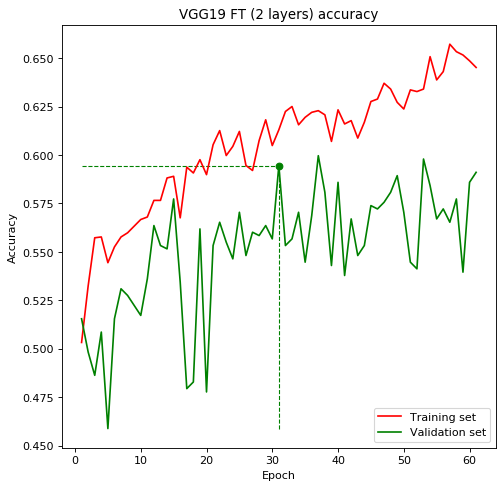

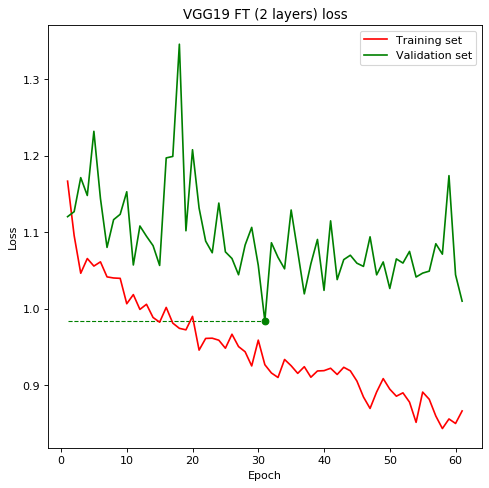

In [46]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [47]:
vgg19_ft_3layer = models.load_model('vgg19_ft_2layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg19_ft_3layer.get_layer('vgg19').layers:
    if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv4'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_ft_3layer.compile(optimizer=RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg19_ft_3layer.summary()
vgg19_ft_3layer.get_layer('vgg19').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 24,219,332
Trainable params: 11,274,372
Non-trainable params: 12,944,960
_________________________________________________________________
Model: "vgg19"
_________________________________________________________________
Layer (type)      

In [48]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg19_ft_3layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [49]:
# Train
history_ft_3layer = vgg19_ft_3layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8601 - accuracy: 0.6355
Epoch 00001: val_loss improved from inf to 1.04882, saving model to vgg19_ft_3layer_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 0.8598 - accuracy: 0.6375 - val_loss: 1.0488 - val_accuracy: 0.5842
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8646 - accuracy: 0.6260
Epoch 00002: val_loss did not improve from 1.04882
19/19 [==============================] - 29s 2s/step - loss: 0.8664 - accuracy: 0.6276 - val_loss: 1.0996 - val_accuracy: 0.5739
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8275 - accuracy: 0.6491
Epoch 00003: val_loss improved from 1.04882 to 1.04685, saving model to vgg19_ft_3layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 0.8314 - accuracy: 0.6469 - val_loss: 1.0468 - val_accurac

In [50]:
# Save
models.save_model(vgg19_ft_3layer, 'vgg19_ft_3layer_4cl_end.h5')

In [51]:
# History of accuracy and loss
tra_loss_fe = history_ft_3layer.history['loss']
tra_acc_fe = history_ft_3layer.history['accuracy']
val_loss_fe = history_ft_3layer.history['val_loss']
val_acc_fe = history_ft_3layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_ft_3layer = models.load_model('vgg19_ft_3layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg19_ft_3layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_ft_3layer.evaluate(test_images, test_labels, verbose=False)

print("VGG19 Fine Tuning (3 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 Fine Tuning (3 layers)

Epoch [end]: 38
Epoch [opt]: 8
Valid accuracy [end]: 0.6100
Valid accuracy [opt]: 0.6065
Test accuracy [end]:  0.5725
Test accuracy [opt]:  0.5786
Valid loss [end]: 1.0328
Valid loss [opt]: 0.9963
Test loss [end]:  1.0167
Test loss [opt]:  0.9976


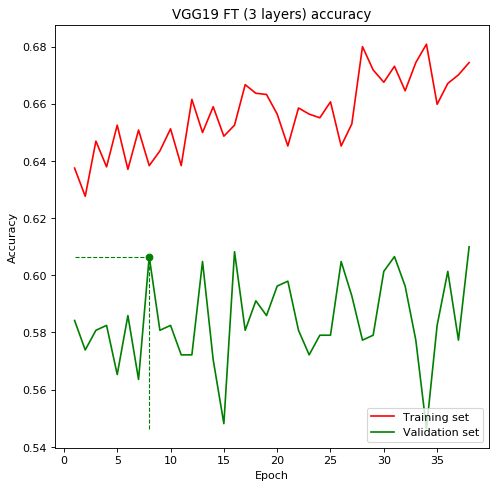

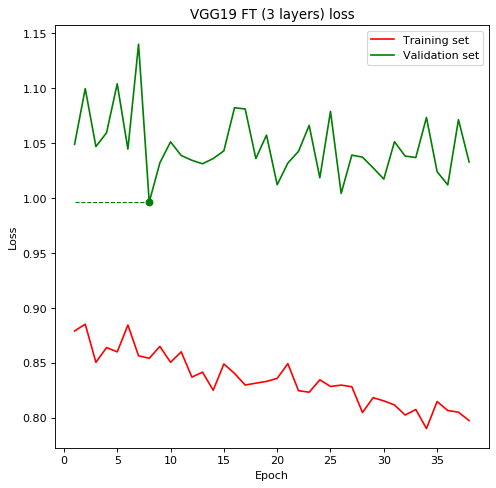

In [52]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT (3 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT (3 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [3]:
vgg19_ft_4layer = models.load_model('vgg19_ft_3layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg19_ft_4layer.get_layer('vgg19').layers:
    if layer.name in ('block5_conv1','block5_conv2', 'block5_conv3', 'block5_conv4'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_ft_4layer.compile(optimizer=RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg19_ft_4layer.summary()
vgg19_ft_4layer.get_layer('vgg19').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 24,219,332
Trainable params: 13,634,180
Non-trainable params: 10,585,152
_________________________________________________________________
Model: "vgg19"
_________________________________________________________________
Layer (type)      

In [4]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg19_ft_4layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [10]:
# Train
history_ft_4layer = vgg19_ft_4layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9363 - accuracy: 0.6169
Epoch 00001: val_loss improved from inf to 0.83585, saving model to vgg19_ft_4layer_4cl_best.h5
19/19 [==============================] - 33s 2s/step - loss: 0.9363 - accuracy: 0.6135 - val_loss: 0.8359 - val_accuracy: 0.6546
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8872 - accuracy: 0.6455
Epoch 00002: val_loss did not improve from 0.83585
19/19 [==============================] - 29s 2s/step - loss: 0.8861 - accuracy: 0.6478 - val_loss: 0.8376 - val_accuracy: 0.6598
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8781 - accuracy: 0.6396
Epoch 00003: val_loss did not improve from 0.83585
19/19 [==============================] - 29s 2s/step - loss: 0.8678 - accuracy: 0.6465 - val

18/19 [===========================>..] - ETA: 1s - loss: 0.7397 - accuracy: 0.6850
Epoch 00057: val_loss did not improve from 0.78307
19/19 [==============================] - 29s 2s/step - loss: 0.7398 - accuracy: 0.6868 - val_loss: 0.8393 - val_accuracy: 0.6735
Epoch 58/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7603 - accuracy: 0.6909
Epoch 00058: val_loss did not improve from 0.78307
19/19 [==============================] - 29s 2s/step - loss: 0.7633 - accuracy: 0.6890 - val_loss: 0.8468 - val_accuracy: 0.6478
Epoch 59/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7538 - accuracy: 0.6904
Epoch 00059: val_loss did not improve from 0.78307
19/19 [==============================] - 29s 2s/step - loss: 0.7561 - accuracy: 0.6890 - val_loss: 0.8225 - val_accuracy: 0.6804
Epoch 60/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7350 - accuracy: 0.6931
Epoch 00060: val_loss did not improve from 0.78307
19/19 [==============================]

Epoch 87/200
18/19 [===========================>..] - ETA: 1s - loss: 0.6957 - accuracy: 0.7149
Epoch 00087: val_loss did not improve from 0.77961
19/19 [==============================] - 29s 2s/step - loss: 0.7035 - accuracy: 0.7143 - val_loss: 0.8455 - val_accuracy: 0.6581
Epoch 88/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7216 - accuracy: 0.7013
Epoch 00088: val_loss did not improve from 0.77961
19/19 [==============================] - 30s 2s/step - loss: 0.7228 - accuracy: 0.7023 - val_loss: 0.8245 - val_accuracy: 0.6649
Epoch 89/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7493 - accuracy: 0.6931
Epoch 00089: val_loss did not improve from 0.77961
19/19 [==============================] - 30s 2s/step - loss: 0.7457 - accuracy: 0.6950 - val_loss: 0.8108 - val_accuracy: 0.6546
Epoch 90/200
18/19 [===========================>..] - ETA: 1s - loss: 0.6991 - accuracy: 0.7167
Epoch 00090: val_loss did not improve from 0.77961
19/19 [==================

In [11]:
# Save
models.save_model(vgg19_ft_4layer, 'vgg19_ft_4layer_4cl_end.h5')

In [12]:
# History of accuracy and loss
tra_loss_fe = history_ft_4layer.history['loss']
tra_acc_fe = history_ft_4layer.history['accuracy']
val_loss_fe = history_ft_4layer.history['val_loss']
val_acc_fe = history_ft_4layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_ft_4layer = models.load_model('vgg19_ft_4layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg19_ft_4layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_ft_4layer.evaluate(test_images, test_labels, verbose=False)

print("VGG19 Fine Tuning (3 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 Fine Tuning (3 layers)

Epoch [end]: 105
Epoch [opt]: 75
Valid accuracy [end]: 0.6598
Valid accuracy [opt]: 0.6959
Test accuracy [end]:  0.5618
Test accuracy [opt]:  0.5786
Valid loss [end]: 0.8632
Valid loss [opt]: 0.7796
Test loss [end]:  1.1676
Test loss [opt]:  1.1105


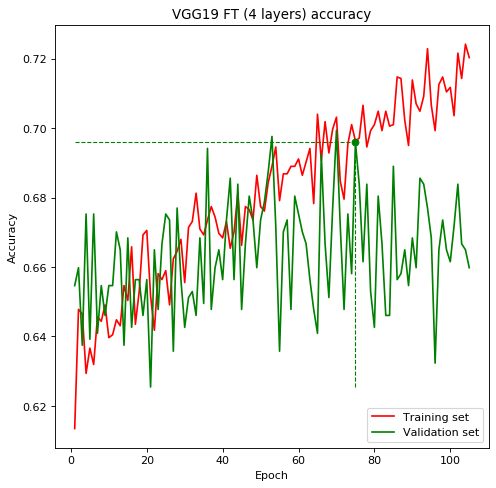

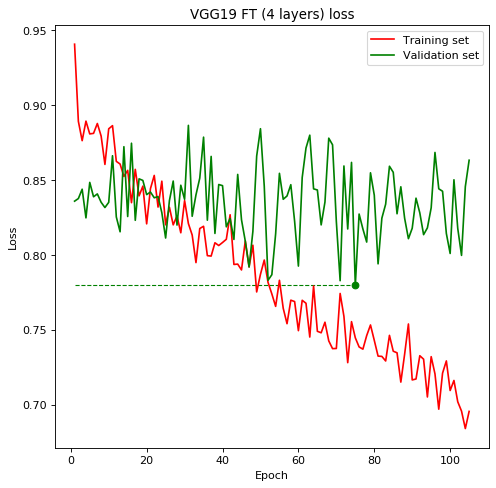

In [13]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT (4 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT (4 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();